<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab06_classification/timit-1.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 
# FRAME CLASSIFICATION
## Comparing different Feature Vectors: MELFB vs.MFCC vs. MELPCA
_______________
+ ###### Author: Dirk Van Compernolle   
+ ###### Modification History: --/--/2020, 25/04/2022, 25/02/2025
+ ###### Requires:  pyspch>=0.8 

### 1. Setting up

In [1]:
####################################################################################
### This setting is to avoid memory leaks in sklearn KMEANS on windows+MKL machines 
### This must be executed before importing numpy (here or in other packages) 
import os
os.environ["OMP_NUM_THREADS"] = '1'  
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import sys,os,io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns
import scipy.io as sio
import urllib.request

# import from the scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture
# import the DCT transform from scipy
from scipy.fftpack import dct
from sklearn.decomposition import PCA

from pyspch.stats import GMM
import pyspch.core as Spch

palette = sns.color_palette("bright")
sns.set_palette(palette)
pd.set_option('display.precision',2)

mpl.rcParams['figure.figsize'] = [10.0, 10.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

### 2. The Database - TinyTIMIT
The experiments in this notebook use a tiny subset of the [TIMIT](../data/TIMIT.md) database.
From the whole database we randomly selected 1000 frames each for 3 vowels (aa, iy, uw). 
800 samples per class are used for training and 200 samples for testing.
In this way we create a very simple 3 class recognition problem.
Preprocessed 24 mel filterbank feature vectors are loaded as 'tinytimit'.

The loaded data consists of:
- data matrices   MELFB_train(2400,24), MELFB_test(600,24)
- labels          y_train(2400,), y_test(600,)

At this point we also precompute different representations MFCC and PCA. Details follow later in the notebook.

In [4]:
# load MELFB features from disk
(MELFB_train, MELFB_test, y_train, y_test) = Spch.load_data('tinytimit')
classes = ['aa','iy','uw']

# compute MFCC features using a DCT transform
MFCC_train = dct(MELFB_train, type=2, axis=1, norm='ortho')
MFCC_test = dct(MELFB_test, type=2, axis=1, norm='ortho')

# compute PCA features using a PCA transform
pca = PCA()
T = pca.fit(MELFB_train)
PCA_train = T.transform(MELFB_train)
PCA_test = T.transform(MELFB_test)

## 3. Data Exploration 

### 3a. Mel Filterbank data

It is interesting to know how our data is distributed over the different classes in our data space. 
But how to visualize data in 24-dimensional space ? There is no trivial answer to this question.  

When working with 2D data we can see this with a scatter plot (see e.g. the F1-F2 scatter plots for vowels).
For somewhat higher dimensional we can view a grid of scatter plots.  However, this is barely feasible for our 24D feature vectors.
Therefore we will start of with making scatter plots of a small subselection of our 24D feature vector.

##### Tasks & Questions (1)
1. Make scatter plots for a subselection of filterbank features.  You specify your selection in the first line of the code cell below.   
   a. Select the first 4 channels
   > ftr_selection = range(0,4,1)
    
   b. Select 4 equally spaced channels spanning the whole frequency range
   > ftr_selection = range(0,24,6)
     
2. Which subset of both features would work best for performing the 3 vowel recognition task ?  Can you also explain why ?

SELECTED FEATURES (MELFB channels): ['melfb0', 'melfb1', 'melfb2', 'melfb3']


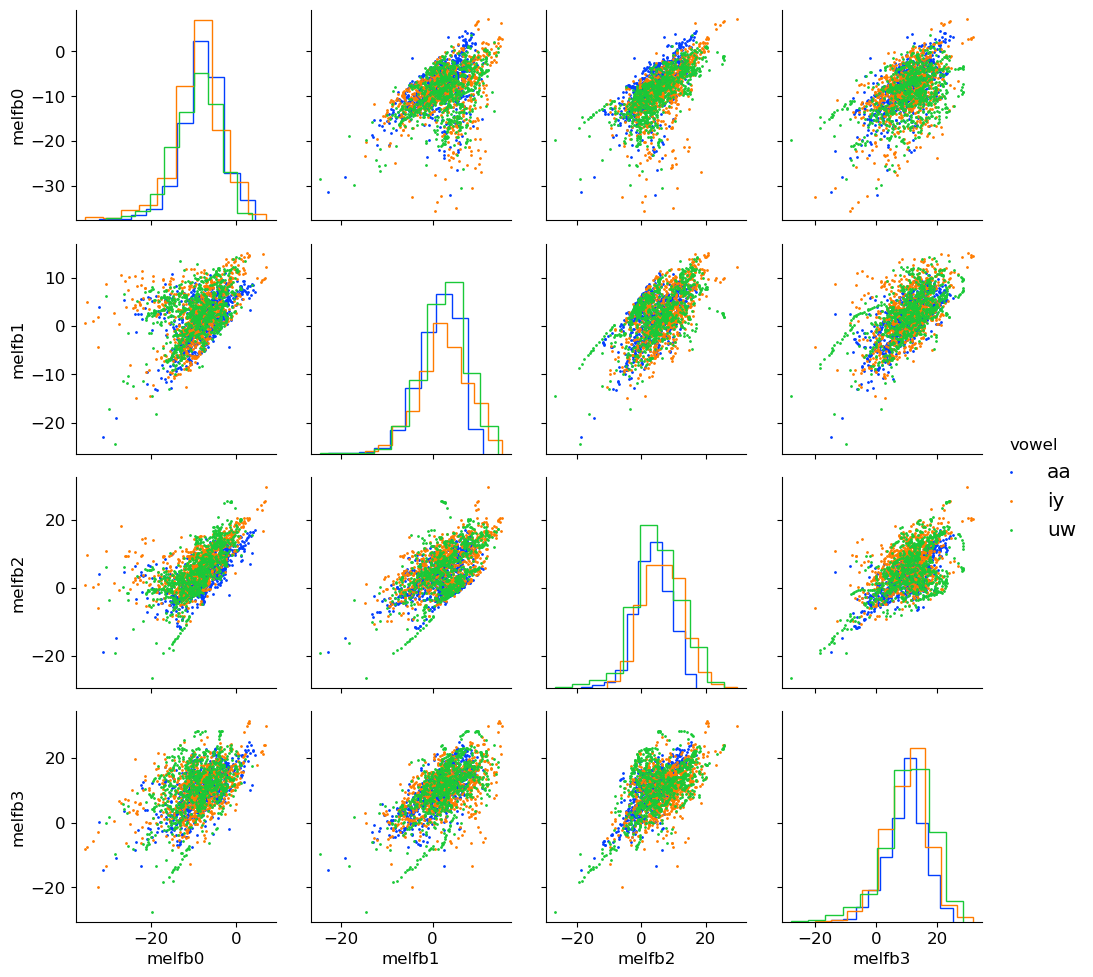

In [5]:
######### specify the selected channels here ###########
ftr_selection = range(0,4,1)
#ftr_selection = range(0,24,6)
########################################################
ftr_str = [ "melfb"+str(i) for i in ftr_selection ]
print("SELECTED FEATURES (MELFB channels):", ftr_str)
dfX = pd.DataFrame(MELFB_train[:,ftr_selection])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
df.columns=["vowel"] + ftr_str
g = sns.PairGrid(df,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=1)
g.add_legend();

### 3b. MFCC features
 

#### About MFCCs
MFCC's (Mel Frequency Cepstrum Coeffiecients) are obtained by taking an IDCT (discrete cosine transform) of log filterbank energies, i.e. the MELFB features that we used above.

The IDCT decomposes the data sequence in terms of a sum of cosine functions oscillating at different frequencies.  Hence the low order coefficients contribute mainly to the overall shape of the sequence, while the high order coefficients will fill in high frequency detail.
Transforming this to the MFCC case, we can state that the lower order MFCCs stand for the spectral envelope, while the high order coefficients fill in spectral details such as pitch.

We will discover that these MFCCs exhibit some very nice properties: (i) truncation to a small number (13) of coefficients seems to capture all relevant information and (ii) they are highly decorrelated.  As such the MFCC-13 feature vector is a compact feature vector with excellent properties from a machine learning point of view.
For all these reasons MFCCs have been a reference feature representation for speech recognition for decades.  While, maybe not a favorite anymore in today's large DNN systems, MFCCs are still very relevant for development, prototyping or embedded applications.

First we compare prototypical values for our 3 vowels both as MELFB and as MFCC.
You immediately observe that 'human' interpretation of the MELFB is more intuitive than with MFCC.  However, this human intuition and interpretability does not trivially carry over to a machine learning environment.

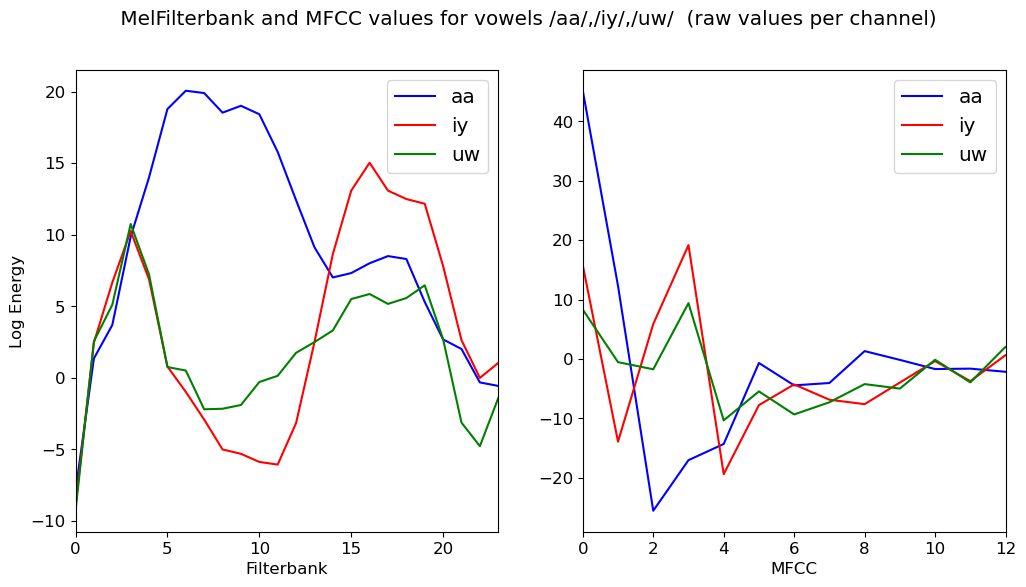

In [6]:
#  set MEAN_NORM to True if you want to display mean normalized values
#  leave MEAN_NORM at False if you want to display raw values
MEAN_NORM = False

# Precomputed when loading the MELFB features
#MFCC_train = dct(MELFB_train, type=2, axis=1, norm='ortho')
#MFCC_test = dct(MELFB_test, type=2, axis=1, norm='ortho')


if MEAN_NORM:
  MELFBmean = np.mean(MELFB_train,0)
  MFCCmean = np.mean(MFCC_train,0)
else:
  MELFBmean = 0
  MFCCmean = 0

MELFB_typ_aa = np.mean(MELFB_train[0:800,:],0) - MELFBmean
MELFB_typ_iy = np.mean(MELFB_train[800:1600,:],0) - MELFBmean
MELFB_typ_uw = np.mean(MELFB_train[1600:2400,:],0) - MELFBmean
MFCC_typ_aa = np.mean(MFCC_train[0:800,:],0) - MFCCmean
MFCC_typ_iy = np.mean(MFCC_train[800:1600,:],0) -MFCCmean
MFCC_typ_uw = np.mean(MFCC_train[1600:2400,:],0) -MFCCmean


fig= plt.figure(figsize=(12,6))

ax = fig.add_subplot(121)
ax.plot(MELFB_typ_aa,color='blue')
ax.plot(MELFB_typ_iy,color='red')
ax.plot(MELFB_typ_uw,color='green')
ax.legend(['aa','iy','uw'])
ax.set_xlabel('Filterbank')
ax.set_xlim(0,23)
ax.set_ylabel('Log Energy')
#plt.show()

ax = fig.add_subplot(122)
ax.plot(MFCC_typ_aa,color='blue')
ax.plot(MFCC_typ_iy,color='red')
ax.plot(MFCC_typ_uw,color='green')
ax.legend(['aa','iy','uw'])
ax.set_xlabel('MFCC')
ax.set_xlim(0,12)
ax.set_ylabel('')
if MEAN_NORM:
  plt.suptitle(' MelFilterbank and MFCC values for vowels /aa/,/iy/,/uw/  (mean normalization per channel)')
else:
  plt.suptitle(' MelFilterbank and MFCC values for vowels /aa/,/iy/,/uw/  (raw values per channel)')
#plt.savefig("vow3_MELFBvsMFCC")
plt.show()

#### Tasks & Questions (2)

First of all we will repeat the data exploration that we did with MELFB with MFCC and start with the grid of scatter plots.   
1. Make scatter plots for a subselection of MFCC features.  You specify your selection in the first line of the code cell below.   
   a. Select the first 4 MFCCs
   > ftr_selection = range(0,4,1)
    
   b. Select 4 higher order MFCCs
   > ftr_selection = range(9,13,1)
     
2. Which of both subsets will work best for performing the 3 vowel recognition task ?  Can you also explain why ? 
3. Of all the feature selections you have observed so far, which one would work the best for vowel recognition ?

SELECTED FEATURES:  ['mfcc0', 'mfcc1', 'mfcc2', 'mfcc3']


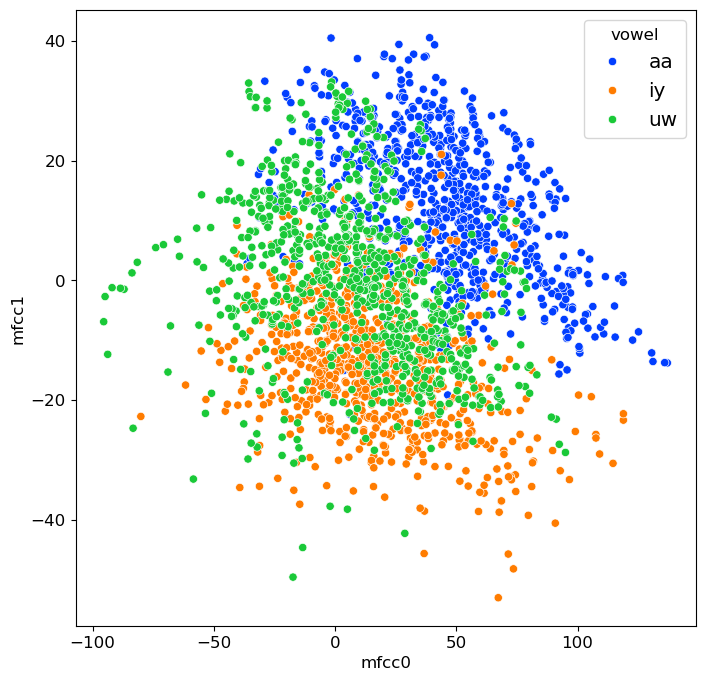

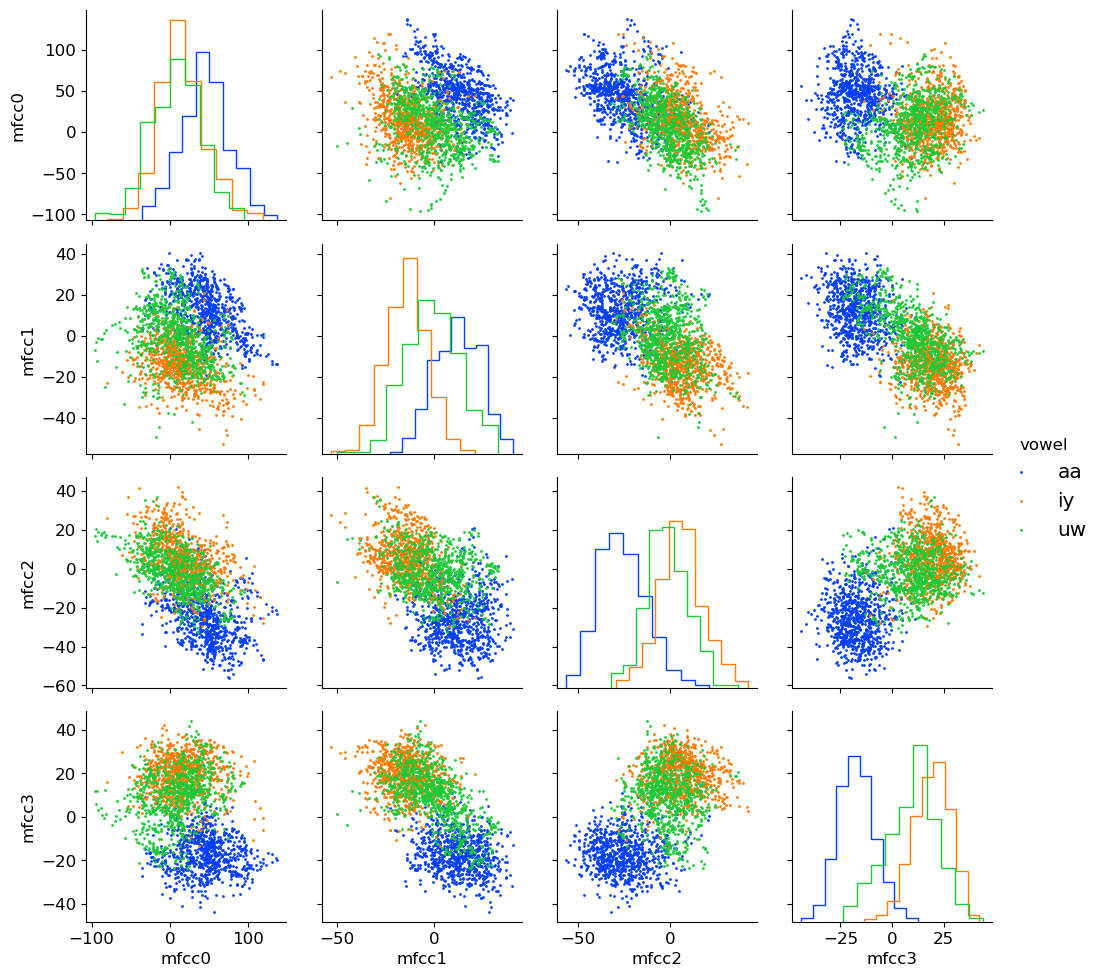

In [7]:
######### specify the selected MFCCs here ###########
ftr_selection = range(0,4,1)
#ftr_selection = range(9,13,1)
#####################################################
ftr_str = [ "mfcc"+str(i) for i in ftr_selection ]
print("SELECTED FEATURES: ",ftr_str)
dfX = pd.DataFrame(MFCC_train[:,ftr_selection])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
df.columns=["vowel"] + ftr_str
#
f=plt.figure(figsize=(8,8))
sns.scatterplot(data=df,x=ftr_str[0],y=ftr_str[1],hue='vowel')
g = sns.PairGrid(df,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=1)
g.add_legend();

### 3c. Principle Component Analysis (PCA)

PCA is a very common technique in machine learning in general to achieve dimensionality reduction, especially when we are dealing with unsupersived settings. It is not commonly used in tasks where we have plenty of labeled data, as is the case for speech recognition.   In such circumstances two alternatives give consistently better performance: LDA or CEPSTRAL transformations.  LDA is a generic technique that learns an optimal linear transformation from labeled data, the cepstrum is a deterministic technique known to work well with speech filterbank data.
Both are linear transformations, similar to PCA, but conceptually quite different
- PCA looks at the global data and gives a look along the most informative axes.  After transformation the global data is centered at the origin and almost normally distributed.
- LDA is also a global transformation, however it takes class information into account in its optimization criterion.  LDA makes gross assumptions, namely that all classes are normally distributed with identical covariances.  Despite these unrealistic assumptions, LDA tends to  outperform PCA by a rather large margin in most machine learning tasks, including speech recognition. Another disadvantage of LDA is that it is learned from the labeled data, making it dependent on language, task and even database.

While there might be lots of information in this 24-dimensional data. It is not simple to observe it.
Definitely it is not obvious in the first couple of filterbank coefficients as we run into the limitations of our 2-D/3-D visual perception system. 

A common approach for a quick analysis is to project the data on its most important axes by Principal Component Analysis (PCA).   PCA takes a view at the overall data distribution and then projects the data on a number of axes that explain
the data variability best. 
PCA does not look at data labels, hence it is an unsupervised method. 
We will not give any mathematical background here, but just think of looking in the best possible low-dimensional subspace of the full 24-dimensional space.

The scatterplot shows the data along the 2 principle axes.
The gridplot combines scatterplots of different (low order) PCA coefficients; the bottom left hand side of the plots show the raw datapoints; the top right hand side shows density approximations.

##### Tasks & Questions (3)
1. What do these new scatter plots tell you?  Can you make a general statement about the distributions of PCA features ?
2. In what units are the PCA-axis ?
3. Any idea if the original filterbank features will perform better or worse than the PCA features ?
4. If you may only use 2 PCA coefficients, which ones will you choose ?

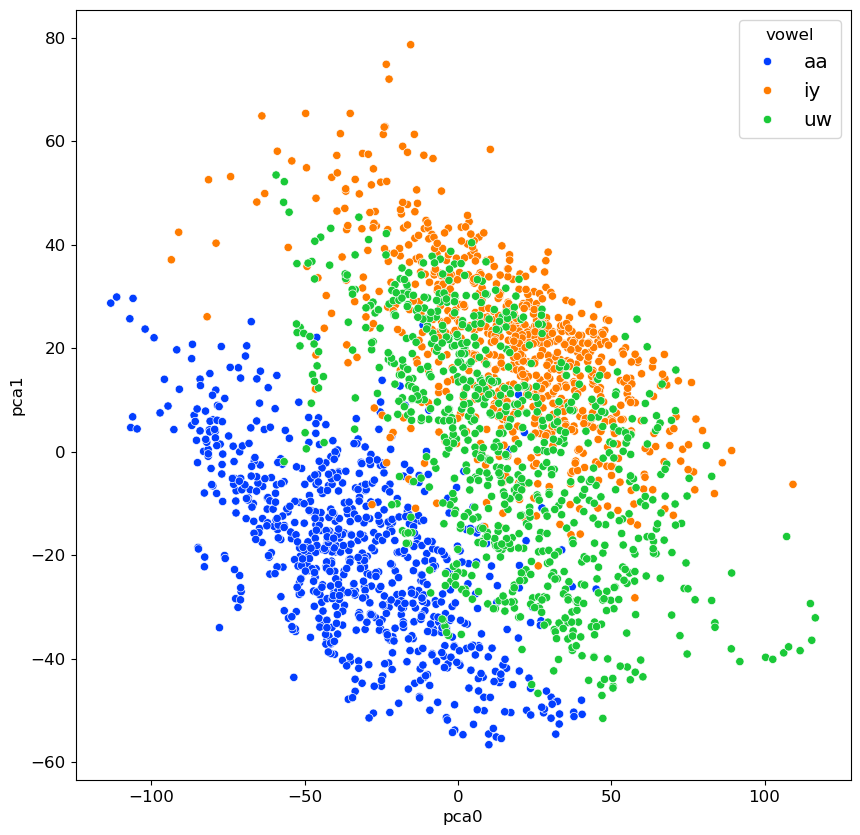

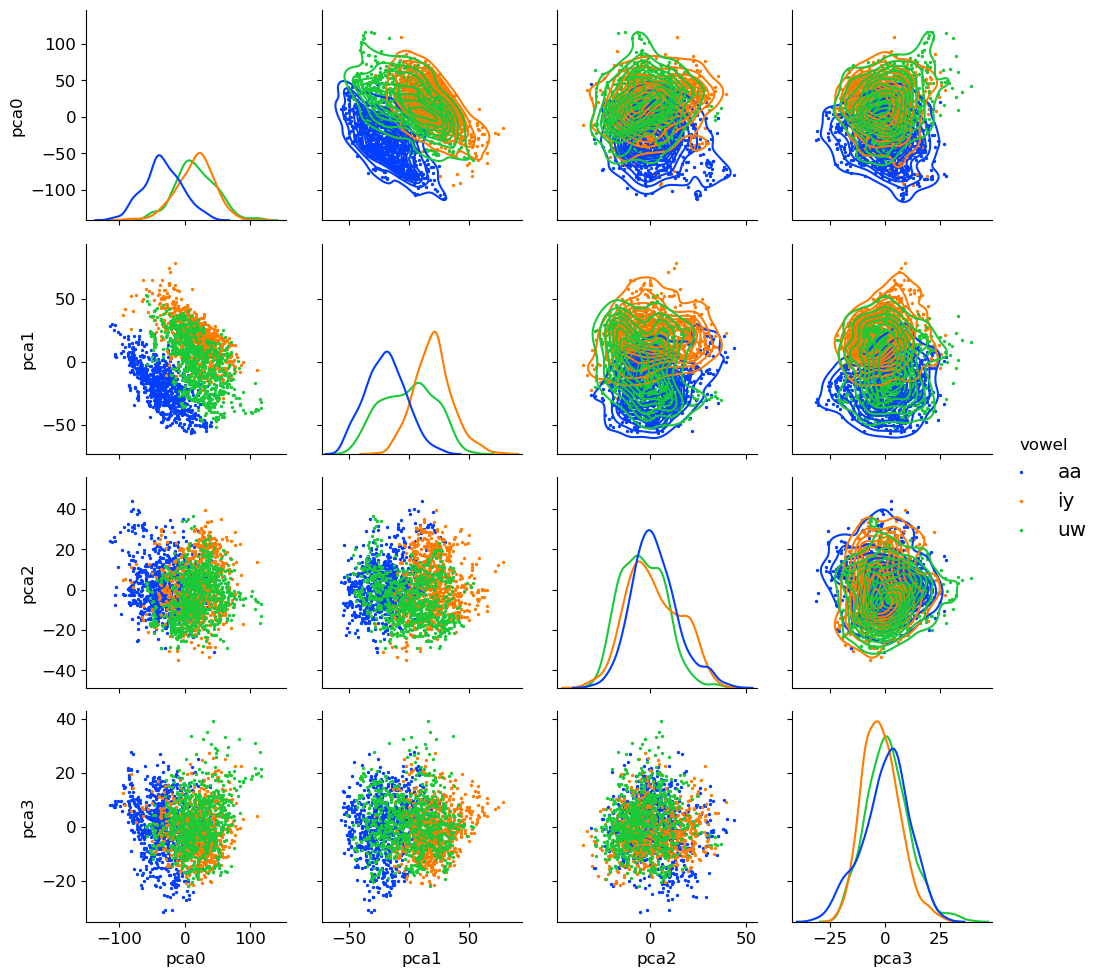

In [8]:
# precomputed when loading the MELFB features
#pca = PCA()
#T = pca.fit(MELFB_train)
#PCA_train = T.transform(MELFB_train)
#PCA_test = T.transform(MELFB_test)
dfX = pd.DataFrame(PCA_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
#
df.columns=["vowel","pca0","pca1","pca2","pca3"]
sns.scatterplot(data=df,x="pca0",y="pca1",hue='vowel')
g = sns.PairGrid(df,hue="vowel")
# on the diagonal we can plot a histogram or a smooth kernel density plot
#g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_diag(sns.kdeplot)
g.map_offdiag(plt.scatter,s=2)
g.map_upper(sns.kdeplot)
g.add_legend()

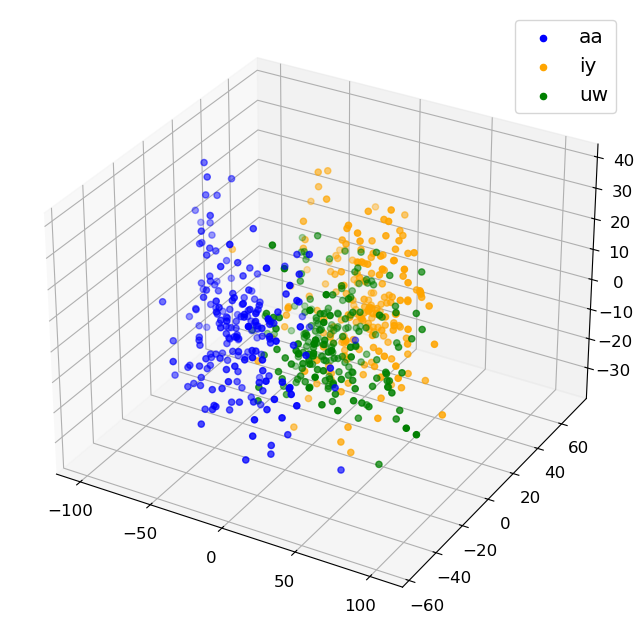

In [9]:
# we can also try to look in 3D ...
# .. but that's the limit of our visual capacity and the data is still 24-D !
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.loc[0:200,"pca0"], df.loc[0:200,"pca1"], df.loc[0:200,"pca2"], c='blue', s=20)
ax.scatter(df.loc[800:1000,"pca0"], df.loc[800:1000,"pca1"], df.loc[800:1000,"pca2"], c='orange', s=20)
ax.scatter(df.loc[1600:1800,"pca0"], df.loc[1600:1800,"pca1"], df.loc[1600:1800,"pca2"], c='green', s=20)
plt.legend(['aa','iy','uw'])
plt.show()


## 4. Classification Experiments using Gaussian Mixture models

In this section we explore the merit of the different representations in function of speech recognition performance.   For modeling we use Gaussian Mixture Models and the inference is straightforward Bayesian.

The following code blocks allow you to run experiments while varying many relevant settings
- n_components:  the number of mixtures used in the Gaussian Mixture Model
- n_dim: the dimension of the feature vector (should be less than 24 in all cases)
- feature_type:  "MELFB", "MFCC" or "PCA"
- max_iter:  maximum number of iterations in EM algorithm 

Students who only need to **interpret** the results for a standard set of parameters
can proceed immediately to **Secion 5.** and there just interpret the plots (Don't run any code below this point!)

Students that have an interest in **performing the different experiments** either with the standard range of parameters or with new settings, you should continue here. 

##### Implementation
We use the implementation as provided in the class *GMM* implemented in *pyspch.stats*. 
It is implemented as an extension to *sklearn*, using the same APIs and making use of the sklearn GaussianMixture density estimator.


##### Training Criteria
GMMs are trained using the EM algorithm which is a hill climbing procedure.  The theory says that the likelihood will increase with every iteration. (Verifying this is in any case a good sanity check for your code!)  But what is now a good stopping criterion ?  

   + Having too many iterations is likely will lead to overfitting the data; i.e. you still see improvement on the training data but you observe degrading performance on the test data.
   + When do we train 'enough' and not 'too much' ?
       - you should stop training when the improvement in LL is marginal, but what is marginal
       - the BIC (Bayesian Information Criterion) may give a hint. It gives a combined measure of goodness of fit (likelihood) and complexity of the model (number of parameters)
       - Best practice, however, is to use an independent validation set (a test set used during training) and to stop when performance on the validation set starts detereorating
    
    
##### Final Performance Measures
The performance measures we report (apart from LL and BIC) are:
- error rate: on (traning set and) an independent test set
- confusion matrix: given some insight in the specific errors we can expect



##### Task & Questions (4)
1. How important in n_dim ?
2. How important is n_components ?
3. How similar is test performance on an independent test set when compared with predicted performance from train set ?  Do you see differences between the 3 different feature types?  Do you see differences with increasing feature dimension and number of components ?

In [10]:
# sklearn is not the most solid implementation of GMMs and produce
# quite a few warnings, which we neglect to focus on other relevant parameters
#
# if you want to see LL evolve during training, you should add
#  "verbose=0,verbose_interval=1" to the GMM parameters
#
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def train_model(X_train,y_train,classes,n_components=1,max_iter=10,tol=1.e-2,Verbose=False):
    clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=max_iter,tol=tol)
    clf_GMM.fit(X_train,y_train)
    ll, bic = clf_GMM.ll_and_bic(X_train,y_train)
    y_pred = clf_GMM.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    if Verbose:
        print('Training Set:  Accuracy = %.2f%%' % (acc_train) )
        print('Training Measures: LL(per sample) = %.2f    BIC = %.2f ' % (ll,bic) )
    return(clf_GMM,(acc_train,ll,bic))    

def test_model(clf_GMM,X_test,y_test,Verbose=False):
    y_pred = clf_GMM.predict(X_test)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    conf_mat = skmetrics.confusion_matrix(y_test,y_pred)
    if Verbose:
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
        Spch.plot_confusion_matrix(conf_mat,labels=classes)
    return(acc_test,conf_mat)


*** feature_type=MFCC, dim=13, n_components=2 ***
Training Set:  Accuracy = 84.21%
Training Measures: LL(per sample) = -44.67    BIC = 215656.07 
Test Set:      Accuracy = 82.50%


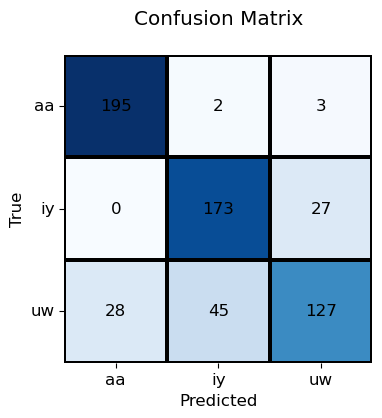

Class[0] (aa) with prior=0.333
-----------------------------------
0.44309658297531884 [ 27.91610884  19.81979164 -20.17522423 -18.23206832 -15.28476334
  -2.47698603  -2.22888432  -7.6530888    1.39706209  -0.82632777
   1.10104311  -1.36005009  -3.61604808] [674.66057592  98.34939261 180.43390204  94.23275875 134.95042241
  85.30387122  62.59681045  41.97686338  36.74730696  28.16446812
  29.95772836  35.59408763  28.63551222]
0.5569034170246812 [ 58.88197215   6.27485309 -29.85809758 -16.11642073 -13.56243648
   0.73357854  -6.2342908   -1.19995764   1.24455913   0.35797316
  -3.94277912  -1.86361572  -1.02302791] [693.75562356  87.96210563 114.01407008  63.52854609  54.70087851
  43.99714486  28.67479232  34.85762523  23.34477573  45.38207228
  14.93638847  12.80548982  25.77138681]

Class[1] (iy) with prior=0.333
-----------------------------------
0.4724256400370689 [ 28.20836178 -14.14825195  -1.15136155  21.97781511 -13.96478096
 -13.17054012  -3.3672299   -5.74771409  -6.50766

In [11]:
# just running the model for a single setup
#
feature_type = "MFCC"  # any of MFCC, MELFB or PCA
n_dim = 13            #  feature dimensions to test
ftr_slice = slice(0,n_dim)  # by default 0:n_dim, other slices possible 
n_components = 2      #  number of GMM components
max_iter = 4
#
print("*** feature_type=%s, dim=%d, n_components=%d ***" % (feature_type,n_dim,n_components))    
X_train = eval("%s_train[:,ftr_slice]"%feature_type)
X_test = eval("%s_test[:,ftr_slice]"%feature_type)
clf,_ = train_model(X_train,y_train,classes=classes,n_components=n_components,max_iter=max_iter,Verbose=True)
_ = test_model(clf,X_test,y_test,Verbose=True)
# model prints mixture weights, means and variances per component per class
clf.print_model()

In [12]:
# in this cell you can do a full scale analysis with multiple settings
# it basically lets you iterate over the same parameters as above
# and summarizes your results in a table

# --------------
feature_type_test = ["MELFB","MFCC","PCA"]   # any of MELFB, MFCC  or PCA
n_dim_test = [ 2, 4, 8, 12, 16, 24 ]         # list of feature dimensions to test
n_components_test = [1, 2, 4,8]              # list of n_components to test
max_iter = 4                                 # maximum number of iterations in the EM algorithm

# --------------
result_list=[]
for feature_type in feature_type_test:
    for n_dim in n_dim_test:  
        for n_components in n_components_test:

            X_train = eval("%s_train[:,0:n_dim]"%feature_type)
            X_test = eval("%s_test[:,0:n_dim]"%feature_type)
          
            clf, (acc_train, ll, bic) = train_model(X_train,y_train,classes,
                                n_components=n_components)
            acc_test, _ = test_model(clf,X_test,y_test)
            result_list.append({"features":feature_type,"dim":n_dim,
                                "n_comp":n_components,
                                "train":acc_train,"test":acc_test,
                                "LL":ll,"BIC":bic})
    
df=pd.DataFrame(result_list,columns=["features","dim","n_comp","train","test","LL","BIC"])

In [13]:
df

,features,dim,n_comp,train,test,LL,BIC
0,MELFB,2,1,41.12,42.67,-6.09,29303.35
1,MELFB,2,2,40.96,38.50,-5.98,28897.77
2,MELFB,2,4,43.75,37.50,-5.82,28375.42
3,MELFB,2,8,45.92,33.33,-5.73,28394.35
4,MELFB,4,1,45.17,39.17,-12.68,61050.20
...,...,...,...,...,...,...,...
67,PCA,16,8,90.04,80.00,-51.09,251350.45
68,PCA,24,1,83.29,79.50,-70.99,341889.77
69,PCA,24,2,84.04,72.50,-70.50,340655.09
70,PCA,24,4,87.54,76.00,-69.66,338929.71


## 5. Detailed Analysis of the Results

In section 4, recognition experiments on our TinyTIMIT database are run with following settings:
- (features) features:  MELFB, MFCC, PCA
- (dim) dimension of feature vector: 2,4,8,12,16,24
- (n_comp) number of components in gaussian mixture: 1,2,4,8
  
All results are gathered in a dataframe 'df'.   
Below we provide a grid of plots showing the accuracy on train and test sets in function of the dimensionality of the feature vector.
The grid spans horizontally the different feature types and vertically the number of components used in the GMM.

Questions (5)
1. How does the importance of 'dimension of feature vector' vary between the different feature representations ?
2. Is there a limit to adding more components to the Gaussian mixtures for this database ?
3. Assess following statement:  "PCA features train well for short feature vectors (dim<10), but are more subject to overtraining when including all 24 components than the other representations"

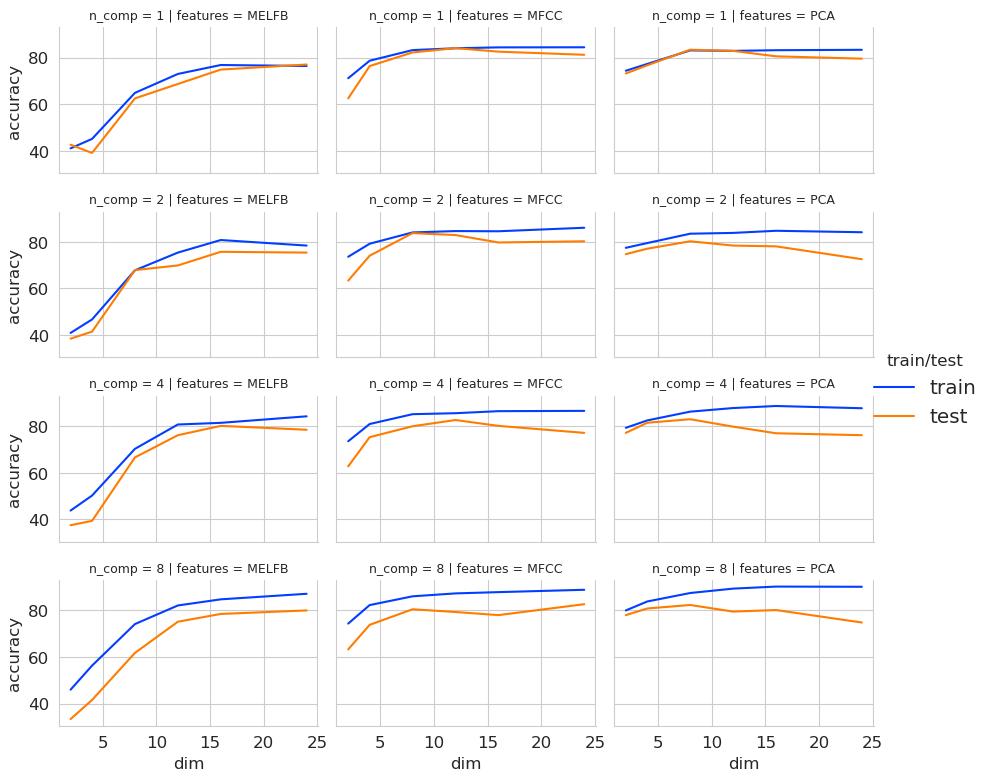

In [14]:
df1=pd.melt(df, id_vars=["features","dim","n_comp"] ,  value_vars=['train', 'test']).rename(columns={ 'variable':'train/test',  'value':'accuracy'})
with sns.axes_style('whitegrid'):
    g=sns.relplot(df1,x="dim",y="accuracy",col="features",hue="train/test",row="n_comp",kind="line",height=2,aspect=1.5)
    g.set_titles(size=9)

#### Plotting Train/Test Accuracies in function of #components in GMM mixture
The number of components in the Gaussian mixture varies from 1 to 8
Remermber that TinyTIMIT is **tiny** as the name suggests.  Be careful not to extrapolate to larger databases.  More realistic results on the full TIMIT dataset are obtained in notebook  timit-3.ipynb .

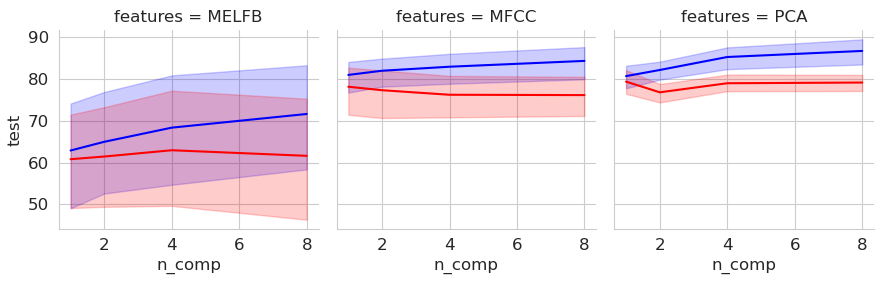

In [15]:
with sns.axes_style('whitegrid'):
    g=sns.FacetGrid(df,col="features") 
    g.map(sns.lineplot,"n_comp","train",color='b')
    g.map(sns.lineplot,"n_comp","test",color='r')

## 6. Classification using a Neural Net

Finally we compare our classification results using Gaussian Mixtures (GMM) with a Neural Net (NN) classifier.  For this application we may use the simplest of all neural nets: a multilayer perceptron (MLP).

We have set acceptable training parameters for you.  The things we are interested in is the impact of different features (type and dimension) and the size of the network.

#### Tasks & Questions (6)
1. When you compare results from the GMM vs NN classifiers, what is the most striking difference that you observe ?
2. How do you rank the different feature representations (MELFB vs. MFCC) ?  Is there a difference between the GMM and NN case ?
3. How do you rank the different feature dimensions (let's say 13 sv. 24) ?  Any notable difference between the GMM and NN case ?
4. After all the performed experiments, pls. judge the following statements
  - MFCCs outperform MELFB features
  - GMMs are better classifiers than NNs


In [16]:
from sklearn.neural_network import MLPClassifier

# ------ different parameters to be explored --------
feature_type_test = ["MELFB", "MFCC"]  # any combination of MFCC, MELFB or PCA
n_dim_test = [ 13, 24 ]   # list of feature dimensions to test
hidden_layers_test = [(256) , (1024), (512,512) ] # , (512) , (1024), (512,512) , (256,256,256) ]  # network configurations
learning_rate_test = [ 0.005 ]   # initial learning rates for the network training

# ----- extra parameters that can be changed, but might be fine for most tests
max_iter = 500  # maximum number of iterations in the backpropagation algorithm
momentum = 0.9  # only for SGD
early_stopping = True
validation_fraction = 0.1

# --------------


results = []
for feature_type in feature_type_test:
  for n_dim in n_dim_test:
    features = feature_type+"("+str(n_dim)+")"
    for hidden_layer_sizes in hidden_layers_test:
        for learning_rate_init in learning_rate_test:
            if feature_type == "PCA":
                X_train = MELFB_pca_train[:,0:n_dim]   
                X_test  = MELFB_pca_test[:,0:n_dim]    
            elif feature_type == "MELFB":
                X_train = MELFB_train[:,0:n_dim]   
                X_test  = MELFB_test[:,0:n_dim]
            elif feature_type == "MFCC":
                X_train = MFCC_train[:,0:n_dim]   
                X_test  = MFCC_test[:,0:n_dim]    

            clf_MLP = MLPClassifier(solver='adam', 
                                    learning_rate_init=learning_rate_init,
                                    hidden_layer_sizes=hidden_layer_sizes,
                                    max_iter=max_iter, alpha=1e-5, random_state=1,
                                    early_stopping=early_stopping,
                                    validation_fraction=validation_fraction)
            clf_MLP.fit(X_train,y_train)

            #print("*** feature_type(dim=%d), hidden layers=%s, lr=%.5f ***" %       (n_dim,hidden_layer_sizes,learning_rate_init))
            y_pred = clf_MLP.predict(X_train)
            train_acc = 100.0*skmetrics.accuracy_score(y_train, y_pred)
            # print('Train Set Accuracy: %.2f%%' % (100.0*train_acc))
            y_pred = clf_MLP.predict(X_test)
            test_acc = 100.0*skmetrics.accuracy_score(y_test, y_pred)
            cmat = skmetrics.confusion_matrix(y_test,y_pred)

            # 3. print and save results            
            print('%s(dim=%d)  layers=%s   lr=%.5f     Train Accuracy:%.2f%%    Test Accuracy: %.2f%%' % (feature_type,n_dim,hidden_layer_sizes,learning_rate_init,train_acc,test_acc))
            results.append([feature_type, n_dim, str(hidden_layer_sizes), learning_rate_init, train_acc, test_acc])

            #new_result = pd.DataFrame({'features':features,"hidden layers":str(hidden_layer_sizes),'lr': learning_rate_init,'train acc': train_acc,'test acc': test_acc})
            #results = pd.concat([results,new_result],ignore_index=True)
                            
df_nn = pd.DataFrame(results,columns=["features","dim", "hidden layers", "lr","train acc","test acc"])            
print_df = df_nn.set_index(["features","hidden layers","lr"])
HTML(print_df.to_html())

MELFB(dim=13)  layers=256   lr=0.00500     Train Accuracy:91.08%    Test Accuracy: 77.17%
MELFB(dim=13)  layers=1024   lr=0.00500     Train Accuracy:84.88%    Test Accuracy: 76.67%
MELFB(dim=13)  layers=(512, 512)   lr=0.00500     Train Accuracy:98.88%    Test Accuracy: 77.67%
MELFB(dim=24)  layers=256   lr=0.00500     Train Accuracy:96.67%    Test Accuracy: 78.83%
MELFB(dim=24)  layers=1024   lr=0.00500     Train Accuracy:98.50%    Test Accuracy: 80.33%
MELFB(dim=24)  layers=(512, 512)   lr=0.00500     Train Accuracy:98.54%    Test Accuracy: 82.33%
MFCC(dim=13)  layers=256   lr=0.00500     Train Accuracy:98.79%    Test Accuracy: 75.50%
MFCC(dim=13)  layers=1024   lr=0.00500     Train Accuracy:97.96%    Test Accuracy: 78.17%
MFCC(dim=13)  layers=(512, 512)   lr=0.00500     Train Accuracy:98.88%    Test Accuracy: 77.83%
MFCC(dim=24)  layers=256   lr=0.00500     Train Accuracy:99.50%    Test Accuracy: 81.50%
MFCC(dim=24)  layers=1024   lr=0.00500     Train Accuracy:98.92%    Test Accurac

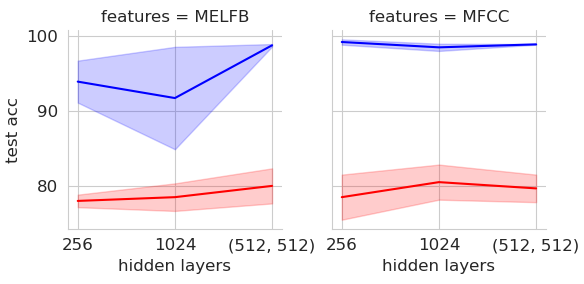

In [17]:
with sns.axes_style('whitegrid'):
    g=sns.FacetGrid(df_nn,col="features") 
    g.map(sns.lineplot,"hidden layers","train acc",color='b')
    g.map(sns.lineplot,"hidden layers","test acc",color='r')